<a href="https://colab.research.google.com/github/Tabatacsantos/Spark/blob/main/Casas_de_SP__ML_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalação do Spark

In [ ]:
#Instando Spark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 9.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=b35c22a4a22244ad041b5db99f66c8f622a08edf8489191d75cb5673811033ba
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# iniciar uma sessão local
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Regressão com Spark") \
    .getOrCreate()

spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color=orange> Previsão de preços de casas na cidade de São Paulo

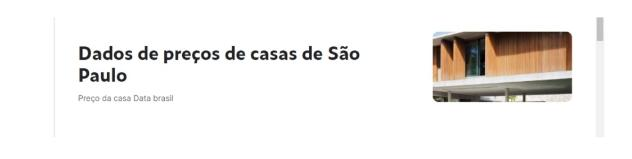


https://www.kaggle.com/datasets/kaggleshashankk/house-price-data-of-sao-paulo

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession

In [ ]:
path = '/content/drive/MyDrive/a-Projetos_DC/HouseSP.txt'
df = spark.read.csv(path, sep=',', inferSchema=True, header=True)

In [ ]:
# Importação das bibliotecas para visualização de gráficos
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Visualização do DataFrame
df.show(truncate=False)

+----------------------------------------------+-------------------+---------+--------+-------+---------+-----+------------+
|Rua                                           |Bairro             |Cidade   |Metragem|Quartos|Banheiros|Vagas|Valor       |
+----------------------------------------------+-------------------+---------+--------+-------+---------+-----+------------+
|Avenida Itacira, 255                          |Planalto Paulista  |São Paulo|1000    |4      |8        |6    |R$ 7.000.000|
|Rua Aurelia Perez Alvarez, 42                 |Jardim dos Estados |São Paulo|496     |4      |4        |4    |R$ 3.700.000|
|Rua Alba Valdez                               |Jardim Reimberg    |São Paulo|125     |4      |3        |2    |R$ 380.000  |
|null                                          |Jardim Morumbi     |São Paulo|310     |3      |2        |4    |R$ 685.000  |
|Rua Tobias Barreto, 195                       |Mooca              |São Paulo|100     |3      |2        |2    |R$ 540.000  |


In [ ]:
#Tamanho do Dataframe
df.count()

10860

In [ ]:
# Informações dos tipos de dados
df.printSchema()

root
 |-- Rua: string (nullable = true)
 |-- Bairro: string (nullable = true)
 |-- Cidade: string (nullable = true)
 |-- Metragem: integer (nullable = true)
 |-- Quartos: integer (nullable = true)
 |-- Banheiros: integer (nullable = true)
 |-- Vagas: integer (nullable = true)
 |-- Valor: string (nullable = true)



In [ ]:
# Split da coluna Valor (contém cifrão) para poder mudar para tipo numérico
from pyspark.sql.functions import split,col
df=df.withColumn("moeda", split(col("Valor"), " ").getItem(0)).withColumn("ValorImovel", split(col("Valor"), " ").getItem(1))

In [ ]:
df.limit(5).toPandas()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,moeda,ValorImovel
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000,R$,7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000,R$,3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000,R$,380.000
3,None,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000,R$,685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000,R$,540.000


In [ ]:
#Excluindo colunas valor, moeda Cidade, e Rua
df = df.drop("moeda","Valor","Rua","Cidade")

In [ ]:
# Conversão dos tipos de dados
from pyspark.sql.types import IntegerType, DoubleType
  
df = df \
  .withColumn("Metragem" ,
              df["Metragem"]
              .cast(IntegerType()))   \
  .withColumn("Quartos",
              df["Quartos"]
              .cast(IntegerType()))   \
  .withColumn("Banheiros"  ,
              df["Banheiros"]
              .cast(IntegerType()))   \
  .withColumn("Vagas"  ,
              df["Vagas"]
              .cast(IntegerType()))   \
  .withColumn("ValorImovel"  ,
              df["ValorImovel"]
              .cast(DoubleType()))   \
              
  
df.printSchema()

root
 |-- Bairro: string (nullable = true)
 |-- Metragem: integer (nullable = true)
 |-- Quartos: integer (nullable = true)
 |-- Banheiros: integer (nullable = true)
 |-- Vagas: integer (nullable = true)
 |-- ValorImovel: double (nullable = true)



In [ ]:
# Contagem de valores nulos
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+--------+-------+---------+-----+-----------+
|Bairro|Metragem|Quartos|Banheiros|Vagas|ValorImovel|
+------+--------+-------+---------+-----+-----------+
|   864|     852|    852|      852|  852|       7285|
+------+--------+-------+---------+-----+-----------+



In [ ]:
# Exclusão dados nulos 
df = df.dropna(how="any")

In [ ]:
# Verificando exclusão
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+--------+-------+---------+-----+-----------+
|Bairro|Metragem|Quartos|Banheiros|Vagas|ValorImovel|
+------+--------+-------+---------+-----+-----------+
|     0|       0|      0|        0|    0|          0|
+------+--------+-------+---------+-----+-----------+



In [ ]:
# Tamanho do DataFrame após exclusão dos dados nulos
df.count()

3572

In [ ]:
# Verificando o shape do pyspark dataframe
print((df.count(), len(df.columns)))

(3572, 6)


# Análises

In [ ]:
#Estatística descritiva
# A média de valor é de R$ 511.919
df\
    .select("Metragem","Quartos","Banheiros","Vagas","ValorImovel")\
    .summary()\
    .show()

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|          Metragem|           Quartos|         Banheiros|            Vagas|      ValorImovel|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|  count|              3572|              3572|              3572|             3572|             3572|
|   mean|246.85834266517358|3.0683090705487124|2.9566069428891377|3.205767077267637|511.9193796192605|
| stddev|249.54990921427193|1.1053866969844086|1.7240514562310012|2.787526784116519| 324.036621017804|
|    min|                10|                 1|                 1|                1|             1.65|
|    25%|               120|                 2|                 2|                2|            257.6|
|    50%|               165|                 3|                 3|                2|            585.0|
|    75%|               270|                 3|                 4|       

##### Histograma valor do imóvel para ver a distribuição dos valores

In [ ]:
df_hist=df.toPandas()

Text(0.5, 1.0, 'Valor Imóvel')

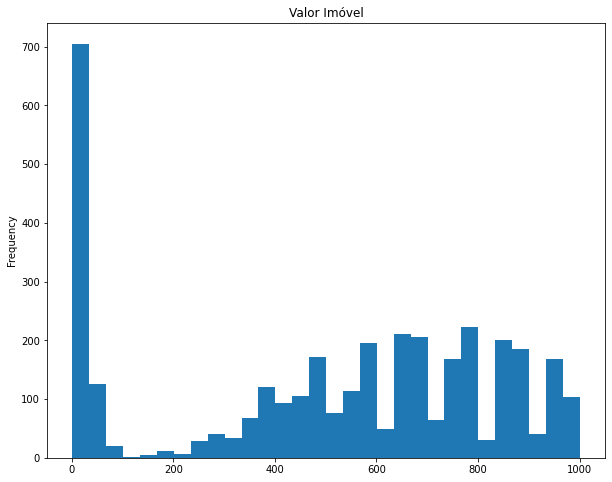

In [ ]:
plt.figure(figsize=(10, 8))
df_hist['ValorImovel'].plot.hist(bins = 30)
plt.title("Valor Imóvel")


##### Quantidade de imóveis por bairro



In [ ]:
# Quantidade de bairros
qtdb=df.select('Bairro').distinct().count()
print(f'Ao todo são  {qtdb} bairros')

Ao todo são  638 bairros


In [ ]:
# Quantidade de imóveis por bairro
# os bairros com maiores quantidades tem de 39 a 52 imóveis
df_b=(df.groupby('Bairro').count()
        .orderBy('count', ascending=False)).show(10)

+-----------------+-----+
|           Bairro|count|
+-----------------+-----+
|     Vila Mariana|   52|
|         Ipiranga|   52|
|   Jardim América|   50|
|  Bosque da Saúde|   50|
|   Jardim Guedala|   50|
|          Cambuci|   47|
|Planalto Paulista|   44|
|  Jardim Paulista|   43|
|Alto de Pinheiros|   40|
|    Cidade Jardim|   39|
+-----------------+-----+
only showing top 10 rows



In [ ]:
data = [["Vila Mariana" , 52], [ "Ipiranga", 52],
      ["Bosque da Saúde"  , 50],["Jardim América", 50], 
        ["Jardim Guedala" ,50],["Cambuci", 47],
        ["Planalto Paulista", 44], ["Jardim Paulista", 43],
          ["Alto de Pinheiros" ,40],["Cidade Jardim",39]]
columns=["Bairro","Quantidade de imoveis"]
dataframe = spark.createDataFrame(data, columns)
dataframe.show()

+-----------------+---------------------+
|           Bairro|Quantidade de imoveis|
+-----------------+---------------------+
|     Vila Mariana|                   52|
|         Ipiranga|                   52|
|  Bosque da Saúde|                   50|
|   Jardim América|                   50|
|   Jardim Guedala|                   50|
|          Cambuci|                   47|
|Planalto Paulista|                   44|
|  Jardim Paulista|                   43|
|Alto de Pinheiros|                   40|
|    Cidade Jardim|                   39|
+-----------------+---------------------+



In [ ]:
dataframe.printSchema()

root
 |-- Bairro: string (nullable = true)
 |-- Quantidade de imoveis: long (nullable = true)



In [ ]:
dataframe=dataframe.toPandas()

Text(0.5, 1.0, 'Top 10 bairros com mais imóveis')

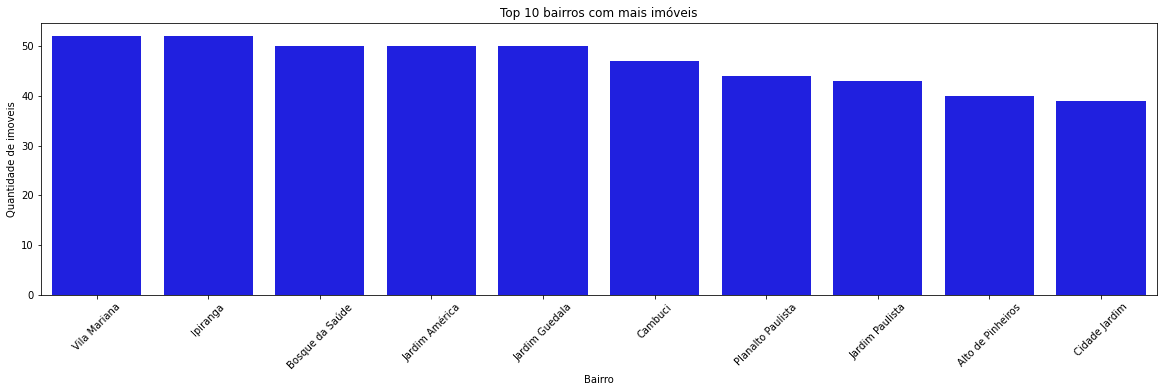

In [ ]:
plt.figure(figsize=(20, 5))
ax = sns.barplot(x="Bairro", y="Quantidade de imoveis", data=dataframe,color = "blue")
ax.tick_params(axis='x', rotation=45)
plt.title("Top 10 bairros com mais imóveis")

In [ ]:
# 10 bairros com maiores médias de valor 
# Os bairros mais caros tem valores entre 964 mil e 990 mil
from pyspark.sql.functions import avg, col, desc
media_Valor_bairro=df.groupBy("Bairro") \
  .agg(avg("ValorImovel").alias("ValorImovel")) \
  .sort(col("ValorImovel").desc()) \
  .show(10)

+-----------------+-----------+
|           Bairro|ValorImovel|
+-----------------+-----------+
|          Pompeia|      990.0|
|     Vila Sabrina|      990.0|
|      Vila Zelina|      990.0|
|   Jardim Bélgica|      990.0|
|        Carandiru|      990.0|
|Vila João Batista|      987.0|
|      Jardim Íris|      980.0|
|       Bela Vista|      960.0|
|    Vila Fiat Lux|      957.0|
|  Jardim Umarizal|      954.0|
+-----------------+-----------+
only showing top 10 rows



In [ ]:
dados = [[ "Pompeia", 990.000], [ "Vila Sabrina", 990.000],
        ["Vila Zelina", 990.000], ["Jardim Belgica", 990.000], 
        ["Carandiru"  ,990.000], ["Vila São Batista" ,987.000],
                ["Jardim Iri", 980.000] ,["Bela Vista", 960.000],
         ["Vila Fiat Lux", 957.000], ["Jardim Umarizal" ,954.000]]
col=["Bairro","Valor"]
data_valor = spark.createDataFrame(dados, col)
data_valor.show()

+----------------+-----+
|          Bairro|Valor|
+----------------+-----+
|         Pompeia|990.0|
|    Vila Sabrina|990.0|
|     Vila Zelina|990.0|
|  Jardim Belgica|990.0|
|       Carandiru|990.0|
|Vila São Batista|987.0|
|      Jardim Iri|980.0|
|      Bela Vista|960.0|
|   Vila Fiat Lux|957.0|
| Jardim Umarizal|954.0|
+----------------+-----+



In [ ]:
data_valor.printSchema()

root
 |-- Bairro: string (nullable = true)
 |-- Valor: double (nullable = true)



In [ ]:
data_valor=data_valor.toPandas()

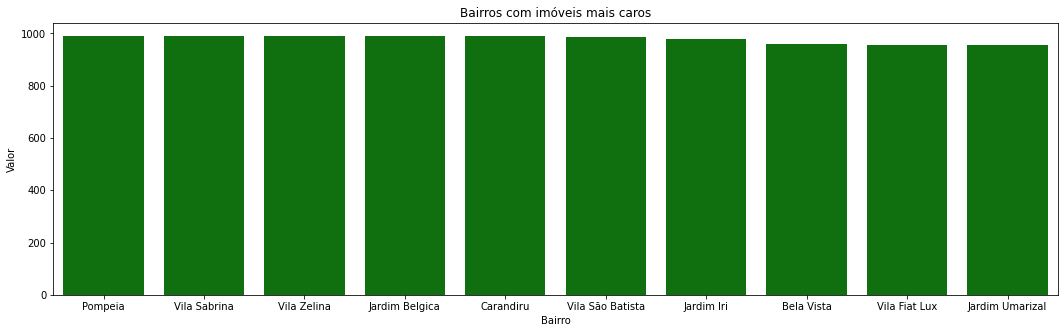

In [ ]:
plt.figure(figsize=(18, 5))
plt.title("Bairros com imóveis mais caros")
sns.barplot(y = 'Valor', x = 'Bairro', data = data_valor, color="green")
plt.show()

In [ ]:
# Valor do Metrô Quadrado
import pyspark.sql.functions as F
from pyspark.sql import functions as F
df2 = df.withColumn("Valor_Metro2", (F.col("ValorImovel") / F.col("Metragem")))
df2.sort(F.desc("Valor_Metro2")).toPandas()

,Bairro,Metragem,Quartos,Banheiros,Vagas,ValorImovel,Valor_Metro2
0,Vila Guaca,10,3,2,2,800.00,80.000000
1,Jardim Ampliação,20,3,2,2,800.00,40.000000
2,Jardim Ampliação,25,3,2,2,800.00,32.000000
3,Jardim Ampliação,25,3,2,2,800.00,32.000000
4,Alto da Lapa,46,1,2,2,945.00,20.543478
...,...,...,...,...,...,...,...
3567,Cidade Jardim,775,5,7,4,8.00,0.010323
3568,Vila Buenos Aires,300,1,4,8,2.80,0.009333
3569,Vila Buenos Aires,305,1,4,8,2.80,0.009180
3570,Brooklin Paulista,647,5,2,5,5.42,0.008377


In [ ]:
# Valor médio do metro quadrado
m2=df2.agg({'Valor_Metro2': 'avg'}).show()

+------------------+
| avg(Valor_Metro2)|
+------------------+
|3.6117143085816337|
+------------------+



In [ ]:
df2=df2.toPandas()

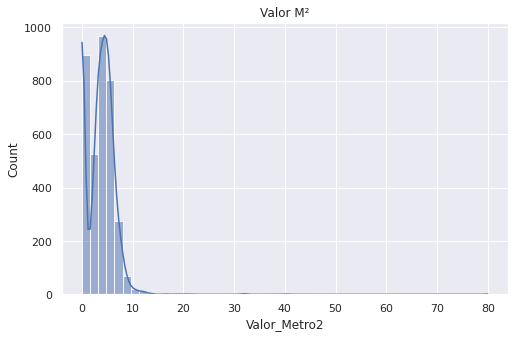

In [ ]:
sns.set()
plt.figure(figsize=(8, 5))
ax = sns.histplot(data = df2, x = "Valor_Metro2", kde = True,bins=50)
ax.set_title("Valor M²")
plt.show()

#Modelos de MLSpark




### Modelo de Regressão Linear

In [ ]:
# Importação do VectorAssembler para vetorizar os dados
from pyspark.ml.feature import VectorAssembler

In [ ]:
# Alterar o nome da coluna Valor imóvel para label 
df = df.withColumnRenamed('ValorImovel','label')

In [ ]:
# Seleção de features
x=['Metragem','Quartos','Banheiros','Vagas']

In [ ]:
# Vetorizando as features 
assembler = VectorAssembler(inputCols = x, outputCol = 'features')

In [ ]:
# Criando novo dataset para efetuar as mudanças
dataset_prep = assembler.transform(df).select('features', 'label')

In [ ]:
# Visualizar o dataset Vetorizado
dataset_prep.show(10, truncate=False)

+-------------------+-----+
|features           |label|
+-------------------+-----+
|[125.0,4.0,3.0,2.0]|380.0|
|[310.0,3.0,2.0,4.0]|685.0|
|[100.0,3.0,2.0,2.0]|540.0|
|[145.0,4.0,4.0,2.0]|850.0|
|[150.0,2.0,2.0,2.0]|450.0|
|[48.0,2.0,1.0,1.0] |199.9|
|[114.0,3.0,3.0,2.0]|585.0|
|[261.0,4.0,4.0,3.0]|700.0|
|[436.0,4.0,3.0,3.0]|15.0 |
|[135.0,3.0,3.0,2.0]|550.0|
+-------------------+-----+
only showing top 10 rows



Visualizando a correlação das variáveis

In [ ]:
# Importação Correlation e pandas
from pyspark.ml.stat import Correlation
import pandas as pd

In [ ]:
# Seleção do dataset para fazer a correlação
correlacao = Correlation.corr(dataset_prep, 'features').collect()

In [ ]:
# Seleção para correlação de Pearson
correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]

In [ ]:
# Tabela de correlação
correlacao.toArray() # transformando em array para ver a tabela
df_corr=pd.DataFrame(correlacao.toArray(), columns=x, index=x)

df_corr

,Metragem,Quartos,Banheiros,Vagas
Metragem,1.000000,0.458296,0.576856,0.645479
Quartos,0.458296,1.000000,0.546269,0.390864
Banheiros,0.576856,0.546269,1.000000,0.529780
Vagas,0.645479,0.390864,0.529780,1.000000


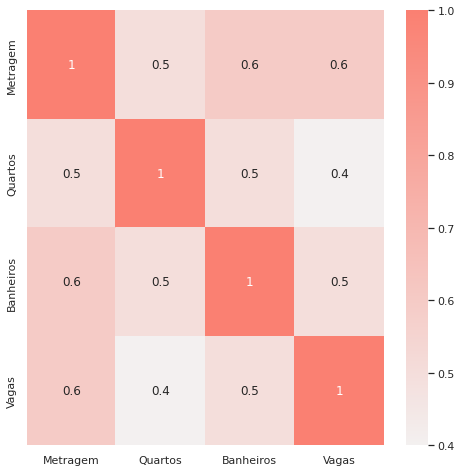

In [ ]:
# Heatmap para visualizar as correlações
# As correlações mais altas são em relação a quantidade de banheiros e tamanho da metragem
plt.figure(figsize=(8,8))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(df_corr.round(1), annot=True, cmap=paleta)

Regressão linear

In [ ]:
# Importação ml spark RL
from pyspark.ml.regression import LinearRegression

In [ ]:
# Definindo treino e teste
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=42)

In [ ]:
treino.count()

2558

In [ ]:
teste.count()


1014

In [ ]:
# Criação do objeto regressor
lr = LinearRegression()

In [ ]:
# Ajuste dos dados
modelo_lr = lr.fit(treino)

Vendo as previsões

In [ ]:
# Gerando previsões
previsoes_lr_treino = modelo_lr.transform(treino)

previsoes_lr_treino.show()

+------------------+-----+-----------------+
|          features|label|       prediction|
+------------------+-----+-----------------+
|[10.0,3.0,2.0,2.0]|800.0|657.2581315368346|
|[20.0,3.0,2.0,2.0]|800.0|653.0404248987254|
|[25.0,3.0,2.0,2.0]|800.0|650.9315715796708|
|[29.0,1.0,1.0,1.0]|300.0|658.9862021406655|
|[35.0,1.0,1.0,1.0]|  2.8|656.4555781577999|
|[36.0,2.0,1.0,1.0]|196.0|673.8010475633329|
|[37.0,1.0,2.0,1.0]|510.0|612.7818553753245|
|[37.0,5.0,5.0,2.0]|690.0|552.9142593880672|
|[40.0,1.0,1.0,1.0]|  2.8|654.3467248387453|
|[42.0,5.0,5.0,2.0]|690.0|550.8054060690125|
|[44.0,1.0,1.0,1.0]|345.0|652.6596421835015|
|[45.0,1.0,1.0,1.0]|160.0|652.2378715196907|
|[46.0,1.0,1.0,1.0]|250.0|651.8161008558798|
|[46.0,2.0,2.0,1.0]|290.0|626.7531594703702|
|[50.0,1.0,1.0,1.0]|289.0|650.1290182006361|
|[50.0,2.0,1.0,1.0]|200.0|  667.89625826998|
|[51.0,1.0,1.0,1.0]|250.0|649.7072475368252|
|[55.0,3.0,1.0,1.0]|345.0|683.5546450202693|
|[57.0,3.0,1.0,5.0]|350.0|672.9270560923568|
|[60.0,1.0

Avaliação do modelo

In [ ]:
# R2 para verificar quanto o modelo está ajustado aos dados
resumo_treino = modelo_lr.summary
resumo_treino.r2

0.23676065412217295

In [ ]:
# RMSE para verificar o erro médio elevado ao quadrado
resumo_treino.rootMeanSquaredError

282.14422653691366

In [ ]:
resumo_teste = modelo_lr.evaluate(teste)
resumo_teste

In [ ]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.236761
RMSE: 282.144227

Dados de Teste
R²: 0.248821
RMSE: 282.986881


### Árvore de decisão

In [ ]:
# Importação ml spark - modelo Árvore de decisão
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
# Criação do objeto regressor
dtr = DecisionTreeRegressor(seed=101, maxDepth=7)

In [ ]:
# Ajuste dos dados
modelo_dtr = dtr.fit(treino)

Vendo as previsões

In [ ]:
# Gerando previsão
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [ ]:
previsoes_dtr_treino.show()

+------------------+-----+------------------+
|          features|label|        prediction|
+------------------+-----+------------------+
|[10.0,3.0,2.0,2.0]|800.0|  579.312676056338|
|[20.0,3.0,2.0,2.0]|800.0|  579.312676056338|
|[25.0,3.0,2.0,2.0]|800.0|  579.312676056338|
|[29.0,1.0,1.0,1.0]|300.0|178.43981818181817|
|[35.0,1.0,1.0,1.0]|  2.8|178.43981818181817|
|[36.0,2.0,1.0,1.0]|196.0|          343.1455|
|[37.0,1.0,2.0,1.0]|510.0| 476.6865490196078|
|[37.0,5.0,5.0,2.0]|690.0|  579.312676056338|
|[40.0,1.0,1.0,1.0]|  2.8|178.43981818181817|
|[42.0,5.0,5.0,2.0]|690.0|  579.312676056338|
|[44.0,1.0,1.0,1.0]|345.0|178.43981818181817|
|[45.0,1.0,1.0,1.0]|160.0|178.43981818181817|
|[46.0,1.0,1.0,1.0]|250.0|178.43981818181817|
|[46.0,2.0,2.0,1.0]|290.0| 476.6865490196078|
|[50.0,1.0,1.0,1.0]|289.0|178.43981818181817|
|[50.0,2.0,1.0,1.0]|200.0|          343.1455|
|[51.0,1.0,1.0,1.0]|250.0|178.43981818181817|
|[55.0,3.0,1.0,1.0]|345.0|          343.1455|
|[57.0,3.0,1.0,5.0]|350.0|343.5714

# Importação do avaliador de regressão do Spark
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator()

In [ ]:
# R2 e RMSE
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))

0.5386687161221743
219.3548521654708


In [ ]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [ ]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.538669
RMSE: 219.354852

Dados de Teste
R²: 0.422926
RMSE: 248.033530
